In [29]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

from tqdm import tqdm

from networks.cnn import CNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [19]:
transform = transforms.Compose([transforms.ToTensor()])
# Download CIFAR10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# Create data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

#create smaller dataset to test with
mini_train_idx = torch.utils.data.SubsetRandomSampler(np.arange(200)) # get the first 200 images
mini_train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, sampler=mini_train_idx) 

Files already downloaded and verified


In [36]:
# Create the model
model = CNN().to(device)
# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 10

In [37]:
# Train the model
progress = tqdm(total=len(train_loader)*EPOCHS, desc="Training") # add a progress bar
for epoch in range(EPOCHS):
    for images, labels in train_loader:
        model.train()
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress.update(1)
    
    progress.write(f'Epoch [{epoch+1}/{10}], Loss: {loss.item():.4f}')

# Save the model checkpoint
torch.save(model.state_dict(), 'model.pth')

Training:   0%|          | 0/7820 [00:59<?, ?it/s]


KeyboardInterrupt: 

In [24]:
# #saving a model
# torch.save(model.state_dict(), "pretrained_cnn.pth")
# print("Saved PyTorch Model State to pretrained_cnn.pth")

#loading the pretrained model
model = CNN()
model.load_state_dict(torch.load("pretrained_cnn.pth"))

Saved PyTorch Model State to pretrained_cnn.pth


<All keys matched successfully>

In [79]:
#testing
model = CNN()
model.load_state_dict(torch.load("pretrained_cnn.pth"))

model.to(device)
model.eval()

transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

criterion = torch.nn.CrossEntropyLoss()

losses = []
accuracies = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        accuracy = (torch.max(outputs, dim=1)[1] == labels).to(torch.float32).mean()
        losses.append(loss.cpu().numpy())
        accuracies.append(accuracy.cpu().numpy())

loss, accuracy = np.mean(losses), np.mean(accuracies)

print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

Loss: 1.1437, Accuracy: 0.6731


In [81]:
# generating adversarial examples
import matplotlib.pyplot as plt

epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "pretrained_cnn.pth"
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the network
model = CNN().to(device)
model.load_state_dict(torch.load(pretrained_model))
# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

# Fast gradient sign method
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [82]:
# Adversarial test (but technically also train)
criterion = torch.nn.CrossEntropyLoss()
def test( model, device, test_loader, epsilon ):
    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for images, labels in test_loader:

        # Send the data and label to the device
        images, labels = images.to(device), labels.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        images.requires_grad = True

        # Forward pass the data through the model
        output = model(images) 
        init_pred = torch.max(output, dim=1)[1] # get the index of the max log-probability

        # Calculate the loss
        loss = criterion(output, labels)

        model.zero_grad()
        loss.backward()

        # Collect datagrad
        data_grad = images.grad.data

        # Call FGSM Attack
        #potential error: pass multiple images instead of image??
        perturbed_data = fgsm_attack(images, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check accuracy
        final_pred = torch.max(output, dim=1)[1] # get the index of the max log-probability
        correct_idx = (final_pred == labels)
        correct += sum(correct_idx.to(torch.float32))
        # print(init_pred, final_pred)
        incorrect_idx = (final_pred != labels)
        # print("incorrect: ", incorrect)
        # print(final_pred[incorrect], init_pred[incorrect])

        #saving examples of perturbed images for later visualization
        if len(adv_examples) < 5:
            # Save some adv examples for visualization later
            for initial, final in zip(init_pred[incorrect_idx], final_pred[incorrect_idx]):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (initial, final, adv_ex) )
            
            # Special case for saving 0 epsilon examples
            if epsilon == 0:
                for initial, final in zip(init_pred[correct_idx], final_pred[correct_idx]):
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (initial, final, adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 6721.0 / 157 = 42.80891799926758
Epsilon: 0.05	Test Accuracy = 0.0 / 157 = 0.0
Epsilon: 0.1	Test Accuracy = 0.0 / 157 = 0.0
Epsilon: 0.15	Test Accuracy = 0.0 / 157 = 0.0
Epsilon: 0.2	Test Accuracy = 2.0 / 157 = 0.012738853693008423
Epsilon: 0.25	Test Accuracy = 3.0 / 157 = 0.019108280539512634
Epsilon: 0.3	Test Accuracy = 10.0 / 157 = 0.06369426846504211


TypeError: Invalid shape (64, 3, 32, 32) for image data

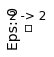

In [84]:
#WIP: print the adversarial examples saved during the above program
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex)
plt.tight_layout()
plt.show()